In [11]:
from pathlib import Path
import pandas as pd

# Match your existing project structure
BASE = Path(r"c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project")
DATA = BASE / "data"
PROC_DIR = DATA / "processed_images"   # 426 images
LABELS_CSV = DATA / "labels.csv"       # keep same schema: image, c01..c64

print("BASE:", BASE)
print("Processed images dir:", PROC_DIR)
print("Labels CSV:", LABELS_CSV)

# Ensure labels.csv exists with expected columns
cols = ["image"] + [f"c{i:02d}" for i in range(1, 65)]
if not LABELS_CSV.exists():
    pd.DataFrame(columns=cols).to_csv(LABELS_CSV, index=False)


BASE: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project
Processed images dir: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\processed_images
Labels CSV: c:\Users\aryan\OneDrive\Desktop\SEM 3\DS 203\DS203-Wildlife-Detection-Project\data\labels.csv


In [12]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import ipywidgets as W
from IPython.display import display

# Load/ensure labels columns
cols = ["image"] + [f"c{i:02d}" for i in range(1, 65)]
def load_labels_df():
    try:
        df = pd.read_csv(LABELS_CSV)
        for c in cols:
            if c not in df.columns:
                df[c] = 0
        return df[cols]
    except Exception:
        return pd.DataFrame(columns=cols)

def list_images(proc_dir: Path):
    valid = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    return sorted([p.name for p in proc_dir.glob("*") if p.suffix.lower() in valid])

def load_image(name: str):
    im = Image.open(PROC_DIR / name).convert("RGB")
    return ImageOps.exif_transpose(im)  # correct phone orientation if needed

def draw_grid_overlay(im: Image.Image, n=8):
    im = im.copy()
    draw = ImageDraw.Draw(im)
    w, h = im.size
    gw, gh = w//n, h//n
    for j in range(1, n):
        x = j*gw; draw.line([(x,0),(x,h)], fill=(255,255,255), width=1)
    for i in range(1, n):
        y = i*gh; draw.line([(0,y),(w,y)], fill=(255,255,255), width=1)
    return im

def show_image(name: str, labels_vec=None, n=8):
    # show image with grid for reference (checkbox UI tracks selections)
    im = draw_grid_overlay(load_image(name), n=n)
    plt.figure(figsize=(6,6))
    plt.imshow(im)
    plt.title(f"{name}  [{state['idx']+1}/{len(state['images'])}]")
    plt.axis("off")
    plt.show()

def get_checked_64():
    vals = []
    for i in range(8):
        for j in range(8):
            vals.append(1 if grid[i][j].value else 0)
    return np.array(vals, dtype=int)

def set_checked_64(vec):
    for k in range(64):
        grid[k//8][k%8].value = bool(vec[k])

def load_existing_labels(df, name):
    if "image" in df.columns and (df["image"] == name).any():
        return df.loc[df["image"] == name, cols[1:]].iloc[0].astype(int).to_numpy()
    return np.zeros(64, dtype=int)


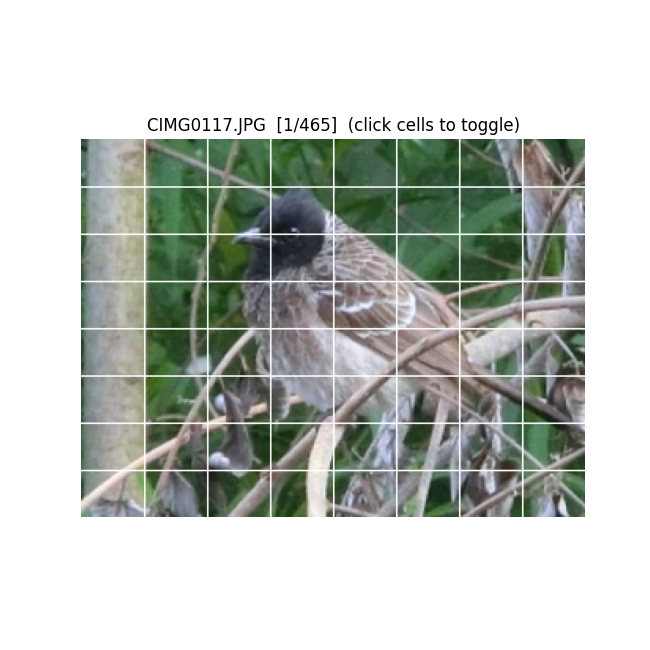

In [13]:
# Try to enable an interactive backend for clickable images
# If ipympl isn't installed, run:  %pip install ipympl   then re-run this cell.
try:
    get_ipython().run_line_magic("matplotlib", "widget")
except Exception:
    pass  # will still render; but clicks require an interactive backend

import numpy as np
import pandas as pd
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt
import ipywidgets as W
from IPython.display import display

# Assumes BASE, DATA, PROC_DIR, LABELS_CSV, cols defined in earlier cells (Cells 1–2).
# Reuse/load labels:
def load_labels_df():
    try:
        _df = pd.read_csv(LABELS_CSV)
        for c in cols:
            if c not in _df.columns:
                _df[c] = 0
        return _df[cols]
    except Exception:
        return pd.DataFrame(columns=cols)

def list_images(proc_dir: Path):
    valid = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    return sorted([p.name for p in proc_dir.glob("*") if p.suffix.lower() in valid])

def load_image_rgb(name: str):
    im = Image.open(PROC_DIR / name).convert("RGB")
    return ImageOps.exif_transpose(im)

def draw_overlay(im: Image.Image, labels_vec, n=8):
    """Draw grid + red rectangles for selected cells."""
    im = im.copy()
    draw = ImageDraw.Draw(im)
    w, h = im.size
    gw, gh = w//n, h//n

    # grid lines
    for j in range(1, n):
        x = j*gw
        draw.line([(x,0),(x,h)], fill=(255,255,255), width=1)
    for i in range(1, n):
        y = i*gh
        draw.line([(0,y),(w,y)], fill=(255,255,255), width=1)

    # selections
    for i in range(n):
        for j in range(n):
            idx = i*n + j
            if labels_vec[idx] == 1:
                x1, y1 = j*gw, i*gh
                x2, y2 = (j+1)*gw, (i+1)*gh
                draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=3)
    return im, gw, gh

def load_existing_labels(df0, name):
    if "image" in df0.columns and (df0["image"] == name).any():
        return df0.loc[df0["image"] == name, cols[1:]].iloc[0].astype(int).to_numpy()
    return np.zeros(64, dtype=int)

# Prepare order (unlabeled first)
df = load_labels_df()
images = list_images(PROC_DIR)
if not images:
    raise FileNotFoundError(f"No files in {PROC_DIR}")

labeled_names = set(df["image"].dropna()) if "image" in df.columns else set()
order = [im for im in images if im not in labeled_names] + [im for im in images if im in labeled_names]

state = {
    "idx": 0,
    "images": order,
    "labels": np.zeros(64, dtype=int),
    "gw": None, "gh": None,
    "fig": None, "ax": None
}

# --- Widgets ---
dd_jump = W.Dropdown(options=order, description="Jump:", layout=W.Layout(width="70%"))
btn_prev = W.Button(description="◀ Prev")
btn_next = W.Button(description="Next ▶ (save)", button_style="primary")
btn_save = W.Button(description="Save", button_style="success")
btn_clear = W.Button(description="Clear")
status = W.HTML()

controls = W.HBox([btn_prev, btn_save, btn_next, btn_clear])
display(W.VBox([dd_jump, controls, status]))

# --- Rendering & interactions ---
def current_name():
    return state["images"][state["idx"]]

def render():
    name = current_name()
    dd_jump.value = name
    # load saved labels (if any)
    state["labels"] = load_existing_labels(df, name)

    base = load_image_rgb(name)
    over, gw, gh = draw_overlay(base, state["labels"], n=8)
    state["gw"], state["gh"] = gw, gh

    if state["fig"] is None or state["ax"] is None:
        state["fig"], state["ax"] = plt.subplots(figsize=(6.5, 6.5))
    ax = state["ax"]
    ax.clear()
    ax.imshow(over)
    ax.set_title(f"{name}  [{state['idx']+1}/{len(state['images'])}]  (click cells to toggle)")
    ax.axis("off")
    state["fig"].canvas.draw_idle()

def onclick(event):
    # only handle clicks within axes and with valid data coords
    if event.inaxes != state["ax"] or event.xdata is None or event.ydata is None:
        return
    gw, gh = state["gw"], state["gh"]
    if not gw or not gh:
        return
    j = int(event.xdata // gw)
    i = int(event.ydata // gh)
    if not (0 <= i < 8 and 0 <= j < 8):
        return
    idx = i*8 + j
    state["labels"][idx] ^= 1  # toggle

    # redraw overlay
    base = load_image_rgb(current_name())
    over, _, _ = draw_overlay(base, state["labels"], n=8)
    state["ax"].clear()
    state["ax"].imshow(over)
    state["ax"].set_title(f"{current_name()}  [{state['idx']+1}/{len(state['images'])}]  (click cells to toggle)")
    state["ax"].axis("off")
    state["fig"].canvas.draw_idle()

def connect_click():
    # disconnect previous if any
    try:
        for cid in list(state.get("_cids", [])):
            state["fig"].canvas.mpl_disconnect(cid)
    except Exception:
        pass
    state["_cids"] = [state["fig"].canvas.mpl_connect("button_press_event", onclick)]

def save_current():
    global df
    name = current_name()
    row = {"image": name}
    for k in range(64):
        row[f"c{k+1:02d}"] = int(state["labels"][k])

    if "image" in df.columns and (df["image"] == name).any():
        df.loc[df["image"] == name, cols[1:]] = state["labels"]
    else:
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df[cols].to_csv(LABELS_CSV, index=False)
    status.value = f"✅ Saved labels for <b>{name}</b>"

def go(delta, save=False):
    if save:
        save_current()
    state["idx"] = max(0, min(len(state["images"]) - 1, state["idx"] + delta))
    render()
    connect_click()

def on_jump(change):
    if change["name"] == "value" and change["new"]:
        state["idx"] = state["images"].index(change["new"])
        render()
        connect_click()

def on_clear(_):
    state["labels"][:] = 0
    render()
    connect_click()
    status.value = "Cleared selections."

# Wire up controls
dd_jump.observe(on_jump)
btn_prev.on_click(lambda _: go(-1, save=False))
btn_next.on_click(lambda _: go(+1, save=True))
btn_save.on_click(lambda _: save_current())
btn_clear.on_click(on_clear)

# Initial render
render()
connect_click()

# Helpful hint if clicks still don’t toggle
backend = plt.get_backend().lower()
if backend not in ("widget", "ipympl", "nbagg", "notebook"):
    status.value = ("⚠ Clicks need an interactive backend. "
                    "Run:<br><code>%pip install ipympl</code><br>"
                    "then:<br><code>%matplotlib widget</code><br>and re-run this cell.")